In [1]:
import os
import json
import spacy
import datasets


ROOT_DIR = "../.."
ORIGINAL_MOCHA_DIR = f"{ROOT_DIR}/data/metric-modeling/mocha"
SPLITS = ("train", "dev", "test")
DATASETS = ('cosmosqa', 'drop', 'mcscript', 'narrativeqa', 'quoref', 'socialiqa')

PREPROC_DIR = f"{ROOT_DIR}/data/raw_splits"
os.makedirs(PREPROC_DIR, exist_ok=True)

In [2]:
filepath = f"{ORIGINAL_MOCHA_DIR}/{SPLITS[0]}.json"

data = json.load(open(filepath))
datasets = list(data.keys())

In [54]:
def read_json_dataset(parent_dir, filename, dataset=None) -> dict:
    """Loads the dataset from the specified path. 
    
    It assumes the dataset is in JSON format and that is
    represented as {tag1: {examples}, tag2: {...}, ...}
    where tag1 and tag2 are dataset tags that the user
    can specify. If none are specified all the datasets
    will be returned.
    """
    data = json.load(open(f"{parent_dir}/{filename}.json"))
    
    if dataset is None:
        datasets = list(data.keys())
    else:
        datasets = dataset if isinstance(dataset, list) else [dataset]
    
    data = {d: datum for d, datum in data.items() if d in datasets}
    return data


# Sanity check (:
data = read_json_dataset(ORIGINAL_MOCHA_DIR, "dev", "narrativeqa")

In [115]:
from bert_score import score as BERT_SCORE
from datasets import load_metric
from pycocoevalcap.meteor.meteor import Meteor as pccMeteor
from pycocoevalcap.rouge.rouge import Rouge as pccRouge
from pycocoevalcap.bleu.bleu import Bleu as pccBleu


def remove_punc(s):
    return s.replace('?', '').replace('.', '').replace('!', '')

def update_examples(examples: dict, key, values):
    assert len(examples) == len(values)

    for example, value in zip(examples, values):
        example[key] = value


def add_bleu(mocha_dataset, order: int=4):
    BLEU = pccBleu(order)

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        
        # compute_scores return (aggregate-bleu, instance-wise bleu)
        # -- by accessing the first index, we get the bleu per instance
        bleu_scores = BLEU.compute_score(refs, cands, verbose=0)[1]
        
        for i in range(order):
            update_examples(examples.values(), f"bleu{i+1}", bleu_scores[i])


def add_meteor(mocha_dataset):
    METEOR = pccMeteor()

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        pred_scores = METEOR.compute_score(refs, cands)[1]
        update_examples(examples.values(), "meteor", pred_scores)


def add_rouge(mocha_dataset):
    ROUGE = pccRouge()

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        pred_scores = ROUGE.compute_score(refs, cands)[1]
        update_examples(examples.values(), "rougeL", pred_scores)

        
def add_bertscore(mocha_dataset):
    for dataset, examples in mocha_dataset.items():
        refs = [remove_punc(instance['reference']) for instance in examples.values()]
        cands = [remove_punc(instance['candidate']) for instance in examples.values()]
        pred_scores = BERT_SCORE(cands, refs, lang='en')[-1].tolist()
        update_examples(examples.values(), "bertscore", pred_scores)


def add_bleurt(mocha_dataset):
    BLEURT = load_metric("bleurt", keep_in_memory=True)

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            scores = BLEURT.compute(predictions=[remove_punc(example["candidate"])],
                                    references=[remove_punc(example["reference"])])
            example["bleurt"] = scores["scores"][0]



def add_char_edit_rate(mocha_dataset):
    """Compute word edit rate. 
    
    The formula is like the character_edit_rate but using words
    rather than characters.
    """
    # https://github.com/huggingface/datasets/tree/fad939b5e17b672a4eda7de2cd8e24d98f3d5b26/metrics/wer
    # !pip install jiwer
    CER = load_metric("cer", keep_in_memory=True)
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"])
            reference = remove_punc(example["reference"])

            scores = CER.compute(predictions=[candidate], references=[reference])
            example["char_edit_score"] = scores


def add_word_edit_rate(mocha_dataset):
    """Compute word edit rate. 
    
    The formula is like the character_edit_rate but using words
    rather than characters.
    """
    # https://github.com/huggingface/datasets/tree/fad939b5e17b672a4eda7de2cd8e24d98f3d5b26/metrics/wer
    # !pip install jiwer
    WER = load_metric("wer", keep_in_memory=True)
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"])
            reference = remove_punc(example["reference"])

            scores = WER.compute(predictions=[candidate], references=[reference])
            example["word_edit_score"] = scores
    
def add_recall(mocha_dataset):
    from collections import Counter

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"]).split()
            reference = remove_punc(example["reference"]).split()

            true_tks, pred_tks = Counter(reference), Counter(candidate)
        
            tp = sum((true_tks & pred_tks).values())
            
            if tp == 0:
                example["recall"] = 0
            else:
                example["recall"] = tp / len(reference)

            example["tp"] = tp
            example["fn"] = len(reference) - tp


def add_precision(mocha_dataset):
    from collections import Counter

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"]).split()
            reference = remove_punc(example["reference"]).split()

            true_tks, pred_tks = Counter(reference), Counter(candidate)
        
            tp = sum((true_tks & pred_tks).values())
            example["precision"] = 0 if tp == 0 else tp / len(candidate)

            example["tp"] = tp
            example["fp"] = len(candidate) - tp


def add_f_score(mocha_dataset, beta=1):
    f_name = f"f{beta}_score"
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            recall = example["recall"]
            precis = example["precision"]
            
            if precis == 0 or recall == 0:
                example[f_name] = 0
            else:
                beta = beta*beta
                num = precis * recall
                den = (beta * precis + recall)
                example[f_name] = (1+beta) * num / den


def add_rouge_order_n(mocha_dataset, rouge_types, use_stemmer=False):
    ROUGE = load_metric("rouge", keep_in_memory=True) 
    #^Note: requires installing rouge-score (!pip install rouge-score)
    # https://github.com/huggingface/datasets/issues/617

    for dataset, examples in mocha_dataset.items():
        candidate = [[remove_punc(ex["candidate"])] for ex in examples.values()]
        reference = [[remove_punc(ex["reference"])] for ex in examples.values()]

        scores = ROUGE.compute(predictions=candidate,
                               references=reference,
                               use_stemmer=use_stemmer,
                               use_aggregator=False)

        for rouge_type in rouge_types:
            rouge_scores = [s.fmeasure for s in scores[rouge_type]]
            update_examples(examples.values(), "hf_" + rouge_type, rouge_scores)


def add_sari(mocha_dataset, source_col="context"):
    """Compute the SARI score.
    
    System output against references and against the input sentence.
    Often used for evaluating automatic text simplification systems.    
    https://github.com/huggingface/datasets/tree/master/metrics/sari.
    
    The range of values for the SARI score is between 0 and 100 -- the
    higher the value, the better the performance of the model being
    evaluated, with a SARI of 100 being a perfect score.
    
    We divide the score by 100 to be on the range (0, 1).
    This score is computed as: 
        sari = ( F1_add + F1_keep + P_del) / 3,
    where
    - F1_add is the n-gram F1 score for add operations
    - F1_keep is the n-gram F1 score for keep operations
    - P_del is the n-gram precision score for delete operations

    The number of n grams, n, is equal to 4, as in the original paper.
    """
    SARI = load_metric("sari", keep_in_memory=True)
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            sources = remove_punc(example[source_col])
            candidate = remove_punc(example["candidate"])
            reference = remove_punc(example["reference"])

            scores = SARI.compute(sources=[sources], predictions=[candidate], references=[[reference]])
            example[f"sari_{source_col}"] = scores["sari"] / 100


def add_prec_rec_at_error1(mocha_dataset):
    """Computes the fraction of correct tokens in prediction until first error."""
    def _get_metric_at_1(reference, candidate):
        if candidate != reference:
            for i, tokens in enumerate(zip(candidate, reference)):
                cand_tk, ref_tk = tokens

                if cand_tk != ref_tk:
                    return 0 if i == 0 or len(reference) == 1 else i/(len(reference)-1)
        return 1
            
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"]).split()
            reference = remove_punc(example["reference"]).split()
            
            example["precision_at_err1"] = _get_metric_at_1(candidate, reference)
            example["recall_at_err1"] = _get_metric_at_1(reference, candidate)


def add_word_movers_distance(mocha_dataset):
    # https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html
    raise NotImplementedError


In [119]:
# add_char_edit_rate(data)
# add_word_edit_rate(data)

# add_recall(data)
# add_precision(data)
# add_f_score(data)
# add_sari(data, "context")
# add_sari(data, "question")
# add_bleu(data)
# add_rouge(data)
# add_rouge_order_n(data, ["rouge1", "rouge2", "rougeL", "rougeLsum"])
add_prec_rec_at_error1(data)
# add_meteor(data)

# add_bertscore(data)
#add_bleurt(data)

In [120]:
data["narrativeqa"]["0005c7718ff653683df879622efb02d1"]

{'candidate': 'his distant relative pascal rougon',
 'context': "The plot centres on the neurotic young priest Serge Mouret, first seen in La ConquĂŞte de Plassans, as he takes his orders and becomes the parish priest for the uninterested village of Artauds. The inbred villagers have no interest in religion and Serge is portrayed giving several wildly enthusiastic Masses to his completely empty, near-derelict church. Serge not only seems unperturbed by this state of affairs but actually appears to have positively sought it out especially, for it gives him time to contemplate religious affairs and to fully experience the fervour of his faith. Eventually he has a complete nervous breakdown and collapses into a near-comatose state, whereupon his distant relative, the unconventional doctor Pascal Rougon (the central character of the last novel in the series, 1893's Le Docteur Pascal), places him in the care of the inhabitants of a nearby derelict stately home, Le Paradou. The novel then ta

In [114]:
for ex in data["narrativeqa"].values():
    if ex["score"] > 3 and ex["precision_error1"] < 0.5:
        print("\nscore:",  ex["score"], "\ncandidate:", ex["candidate"], "\nreference:", ex["reference"])


score: 4.666666666666667 
candidate: his distant relative pascal rougon 
reference: Le Docteur Pascal

score: 4.666666666666667 
candidate: A swim tank. 
reference: Into a swimming take

score: 4.666666666666667 
candidate: A gypsy kid 
reference: Pablo.

score: 5 
candidate: That it was suicide 
reference: It is a Suicide

score: 3.6666666666666665 
candidate: Reign of Numedides 
reference: Numedides.

score: 4.666666666666667 
candidate: a swimming tank 
reference: Into a swimming take

score: 5 
candidate: undergoes a spiritual crisis 
reference: A spiritual crisis she undergoes.

score: 4.333333333333333 
candidate: In Jacob Armitage's isolated cottage in New Forest 
reference: In his isolated cottage

score: 4.666666666666667 
candidate: How there is a relationship between Mary and Frank. 
reference: The seriousness of the relationship between Mary and Frank.

score: 4.333333333333333 
candidate: He collapsed into a near comatose state. 
reference: Serge Moute had a nervous break

<AxesSubplot:ylabel='Count'>

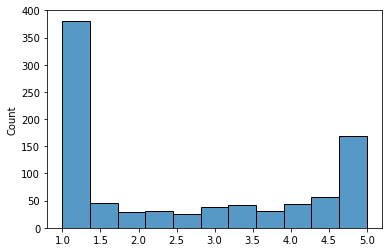

In [101]:
sns.histplot()

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'human judgement')

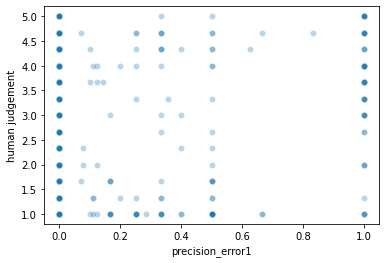

In [109]:

sns.scatterplot([ex["precision_error1"] for ex in data["narrativeqa"].values()], [ex["score"] for ex in data["narrativeqa"].values()], alpha=0.3)
plt.xlabel("precision_error1")
plt.ylabel("human judgement")